# Ingesting

In [190]:
import json
import pandas as pd
from pathlib import Path
import sqlite3

DATA_FILE_PATH = Path.cwd().parent.joinpath("data").joinpath("raw").joinpath("2024_case_cientista_de_dados_ia.csv")
DATABASES_PATH = Path.cwd().parent.joinpath("data").joinpath("databases")

data_file_data_types = {
    "consumidor_id": "int64",
    "cpf_cnpj": "string",
    "nome do consumidor": "string",
    "perfil": "string",
    "divida_id": "string",
    "código_contrato": "string",
    "valor_vencido": "float64",
    "valor_multa": "float64",
    "valor_juros": "float64",
    "produto": "string",
    "loja": "string",
    "Opcoes_Pagamento": "string",
}

df = pd.read_csv(
    filepath_or_buffer=DATA_FILE_PATH,
    dtype=data_file_data_types,
    parse_dates=["data_nascimento", "data_origem"],
    dayfirst=True,
    decimal=",",
)

info_db_connection = sqlite3.connect(DATABASES_PATH.joinpath("info.db"), check_same_thread=False)
df.to_sql(name="customers", con=info_db_connection, if_exists="replace", index=False)

11

# Authentication

In [191]:
import os
from pathlib import Path
import google.auth
import dotenv

_ = dotenv.load_dotenv(dotenv.find_dotenv())

credentials, _ = google.auth.default()

# Tools

In [192]:
from langchain.pydantic_v1 import BaseModel, Field
from langchain.callbacks.manager import CallbackManagerForToolRun
from langchain.tools import BaseTool
from typing import Type, Optional
from textwrap import dedent

class BaseSqlLiteTool(BaseModel):
    """Base tool for interacting with SQLite Database."""
    connection: sqlite3.Connection = Field(exclude=True)
    # Pass sqlite3.Connection validation
    class Config(BaseTool.Config):
        pass


class AuthenticateUserInput(BaseModel):
    cpf: str = Field(
        description="string contendo entre 10 e 11 caracteres numéricos referentes ao CPF do usuário."
    )
    data_nascimento: str = Field(
        description="string com a data de nascimento do usuário no formato 'YYYY-MM-DD'"
    )

class AuthenticateUser(BaseSqlLiteTool, BaseTool):
    name: str = "autenticar_usuario"
    description: str = dedent("""\
        Autentica o usuário. 
        Os inputs são o CPF e a data de nascimento do usuário. 
        Output é uma mensagem informando se o CPF não foi encontrado nos cadastros ou se a data de nascimento não está correta para aquele usuário.
        Ou, caso tenha sido encontrado, o output é um pandas.DataFrame
        """
    )
    args_schema: Type[BaseModel] = AuthenticateUserInput
    def _run(
        self, 
        cpf: str,
        data_nascimento: str,
        run_manager: Optional[CallbackManagerForToolRun]=None,
    ) -> bool:
        cursor = self.connection.cursor()
        if not cursor.execute(f"SELECT * FROM customers WHERE cpf_cnpj = '{cpf}'").fetchone():
            cursor.close()
            return "CPF não encontrado no cadastro da empresa. Checar CPF novamente."
        elif not cursor.execute(f"SELECT * FROM customers WHERE cpf_cnpj = '{cpf}' AND DATE(data_nascimento) = '{data_nascimento}'").fetchone():
            cursor.close()
            return "Os dados informados não foram encontrados no sistema. Checar data de nascimento novamente."
        else:
            df = pd.read_sql_query(f"SELECT * FROM customers WHERE cpf_cnpj = '{cpf}' AND DATE(data_nascimento) = '{data_nascimento}'", self.connection)
            cursor.close()
            return df


authenticate_user_tool = AuthenticateUser(connection=info_db_connection)

tools = [authenticate_user_tool]
tools_by_name = {tool.name: tool for tool in tools}

# Nodes

In [193]:
from textwrap import dedent
from datetime import datetime
from langchain_core.messages import ToolMessage
from langchain_core.prompts import ChatPromptTemplate

TODAY = str(datetime.now().date())

class StartNode():
    def __init__(self):
        pass
    def __call__(self, state):
        if not state["is_authenticated"]:
            return {"is_authenticated": False}
        else:
            return state
    

class AuthenticatorAgentNode():
    def __init__(self, model):
        self.model = model

    def __call__(self, state):
        authenticator_prompt_content = dedent(f"""\
            Definição: 
            Você é um atendente de usuários que são consumidores procurando informações sobre suas dívidas.
                                            
            Objetivo: obter o CPF e data de nascimento dos usuários para autenticá-los. Para isso, interaja com o usuário.
                                    
            Instruções: 
            - O CPF deve conter pelo menos 10 dígitos númericos, mas pode ter mais. O usuário pode enviar esse CPF somente em números (exemplo: 74132341062) ou com pontuação (exemplo: 338.013.350-70). 
            - A data de nascimento também pode ser enviada em diferentes formatos (exemplos: 14/05/2001, 25-02-2000, 14/05/97, 1989-06-06). 
            - Independente do formato enviado pelo usuário, converta a data para YYYY-MM-DD.
            - Considere que os usuários são brasileiros, então é comum que o dia seja apresentado antes do mês na data de nascimento.
            - Se não estiver confiante que o usuário lhe forneceu um CPF e data de nascimento seguindo as regras acima, peça esses dados novamente para ele.
            - Quando obter o CPF e data de nascimento do usuário, você deve chamar a função 'autenticar_usuario'.
            
            Extras:
            - Você sempre deve responder no idioma Português Brasileiro.
            - Hoje é {TODAY}."""
        )
        authenticator_prompt = ChatPromptTemplate.from_messages(
            [
                ("system", authenticator_prompt_content),
                ("placeholder", "{messages}"),
            ]
        )
        return {"messages": [(authenticator_prompt | self.model.bind_tools([authenticate_user_tool])).invoke(state)]}
    
    
class AuthenticatorToolNode():
    def __init__(self, runnable):
        self.runnable = runnable

    def __call__(self, state):
        tool_call = state["messages"][-1].tool_calls[0]
        tool = tools_by_name[tool_call["name"]]
        args = tool_call["args"]
        id = tool_call["id"]
        observation = tool.invoke(args)
        if isinstance(observation, str):
            state["is_authenticated"] = False
            return {"messages": [ToolMessage(content=observation, tool_call_id=id)]}
        else:
            df = observation
            state["is_authenticated"] = True
            state["cpf"] = df["cpf_cnpj"].item()
            state["data_nascimento"] = df["data_nascimento"].item()
            state["nome"] = df["nome"].item()
            state["opcoes_pagamento"] = df["Opcoes_Pagamento"].str.replace('"',"").str.replace("{","{{").str.replace("}","}}").item()
            state["data_origem_divida"] = df["data_origem"].item()
            state["loja"] = df["loja"].item()
            state["produto"] = df["produto"].item()
            state["messages"] = [ToolMessage(content="Usuário autenticado", tool_call_id=id)]
            return state
        

class AuthenticatorOrInfoRouter():
    def __init__(self):
        pass
    def __call__(self, state):
        if state["is_authenticated"]:
            return "to_info"
        else:
            return "to_auth"
            

class ToolRouter():
    def __init__(self):
        pass
    def __call__(self, state):
        print(state)
        if state["messages"][-1].tool_calls:
            return "to_tool"
        else:
            return "to_user"
        

class InformationAgentNode():
    def __init__(self, model):
        self.model = model

    def __call__(self, state):
        information_prompt_content = dedent(f"""\
            Definição: 
            Você é um atendente de usuários que são consumidores procurando informações sobre suas dívidas.
                                            
            Objetivo: 
            Fornecer informações sobre a dívida o usuário. Utilize o contexto do array de JSONs abaixo para extrair todas as informações das dívidas e possíveis opções de pagamento:
                                            
            {state["opcoes_pagamento"]}

            Dados presentes no array de JSONs:
            - opcao_pagamento_id: não informe esse dado ao usuário.
            - valor_entrada: valor que o usuário terá que pagar de entrada.
            - valor_parcela: valor de cada parcela.
            - valor_desconto: valor do desconto total sobre o campo 'valor_negociado'.
            - valor_negociado: valor total da dívida.
            - quantidade_parcelas: número de parcelas a serem pagas para quitar a dívida.
            - data_primeiro_boleto: data do primeiro boleto.
                                    
            Instruções: 
            - O nome completo do usuário é {state["nome"]}. Sempre que adequado, chame-o pelo primeiro nome.
            - A dívida foi iniciada na data de {state["data_origem_divida"]} e refere-se ao produto {state["produto"]} da loja {state["loja"]}
            - Use somente os dados do array de JSONs de contexto para como fonte dos valores e condições de pagamento da dívida.

            Entre as opções que você pode fornecer, estão:
            - Número de opções de pagamento.
            - Características de cada opção de pagamento.
            - Qual é a opção com maior desconto sobre o valor negociado (apresente a porcentagem total de desconto).
            - Qual é a opção que fornece prazo mais longo para pagamento.
            
            Extras:
            - Você sempre deve responder no idioma Português Brasileiro.
            - Hoje é {TODAY}."""
        )
        information_prompt = ChatPromptTemplate.from_messages([
            ("system", information_prompt_content),
            ("placeholder", "{messages}"),
        ])
        return {"messages": [(information_prompt | self.model).invoke(state)]}

# Graph

In [194]:
from typing import Annotated, Union
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, END
from langgraph.graph.message import add_messages
from langchain_google_vertexai import ChatVertexAI
from langgraph.checkpoint.sqlite import SqliteSaver
from langchain_google_vertexai import ChatVertexAI
from langchain_openai import ChatOpenAI

DATABASES_PATH = Path.cwd().parent.joinpath("data").joinpath("databases")
gemini_model = ChatVertexAI(model_name="gemini-1.5-pro-preview-0409", temperature=0.0, max_retries=2)
chatgpt_model = ChatOpenAI(model="gpt-4o", temperature=0, max_retries=2,)
memory = SqliteSaver.from_conn_string(DATABASES_PATH.joinpath("memory.db"))

class State(TypedDict):
    messages: Annotated[list, add_messages]
    is_authenticated: Union[bool, None]
    cpf: Union[str, None]
    data_nascimento: Union[str, None]
    nome: Union[str, None]
    opcoes_pagamento: Union[str, None]
    data_origem_divida: Union[str, None]
    loja: Union[str, None]
    produto: Union[str, None]


graph_builder = StateGraph(State)

graph_builder.add_node("starting_node",  StartNode())
graph_builder.add_node("authenticator_agent", AuthenticatorAgentNode(chatgpt_model))
graph_builder.add_node("authenticator_tool", AuthenticatorToolNode(authenticate_user_tool))
graph_builder.add_node("information_agent", InformationAgentNode(chatgpt_model))

graph_builder.set_entry_point("starting_node")
graph_builder.add_conditional_edges(
    "starting_node",
    AuthenticatorOrInfoRouter(),
    {"to_auth": "authenticator_agent", "to_info": "information_agent",},
)
graph_builder.add_conditional_edges(
    "authenticator_agent",
    ToolRouter(),
    {"to_tool": "authenticator_tool", "to_user": END,},
)
graph_builder.add_conditional_edges(
    "authenticator_tool",
    AuthenticatorOrInfoRouter(),
    {"to_auth": "authenticator_agent", "to_info": "information_agent",},
)
graph_builder.set_finish_point("information_agent")

graph = graph_builder.compile(checkpointer=memory)

In [204]:
from langchain_core.messages import AIMessage

config = {"configurable": {"thread_id": "8"}}
user_input_cpf_errado = "cpf 98254842314 e data de nascimento 18/09/1992"
user_input_cpf_certo = "cpf 64434317075 e data de nascimento 25/09/1989"
user_input_oi = "sim"
user_input_freestyle = "qual a porcentagem de desconto dessa opção?"
# graph.invoke({"messages": [("user", user_input_freestyle)]}, config,)

lis1 = []
for event in graph.stream({"messages": [("user", user_input_cpf_certo)]}, config,):
    lis1.append(event)
    if (
        "messages" in list(event.values())[0]
        and isinstance(list(event.values())[0]["messages"][-1], AIMessage)
        and list(event.values())[0]["messages"][-1].content
    ):
        print(list(event.values())[0]["messages"][-1].content)

{'messages': [HumanMessage(content='cpf 64434317075 e data de nascimento 25/09/1989', id='40bbea1a-1995-4a11-832b-649ea3d36ede'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_g3McImczo9J6Tp7KbzpNZe8V', 'function': {'arguments': '{"cpf":"64434317075","data_nascimento":"1989-09-25"}', 'name': 'autenticar_usuario'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 30, 'prompt_tokens': 436, 'total_tokens': 466}, 'model_name': 'gpt-4o', 'system_fingerprint': 'fp_3e7d703517', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-642eff85-da5a-420a-b0e6-ec7fa1527f33-0', tool_calls=[{'name': 'autenticar_usuario', 'args': {'cpf': '64434317075', 'data_nascimento': '1989-09-25'}, 'id': 'call_g3McImczo9J6Tp7KbzpNZe8V'}], usage_metadata={'input_tokens': 436, 'output_tokens': 30, 'total_tokens': 466})], 'is_authenticated': False}
{'authenticator_agent': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_g3McImc

In [ ]:
from langchain_core.messages import AIMessage

config = {"configurable": {"thread_id": "8"}}
user_input_cpf_errado = "cpf 98254842314 e data de nascimento 18/09/1992"
user_input_cpf_certo = "cpf 64434317075 e data de nascimento 25/09/1989"
user_input_oi = "sim"
user_input_freestyle = "qual a porcentagem de desconto dessa opção?"
# graph.invoke({"messages": [("user", user_input_freestyle)]}, config,)

lis1 = []
for event in graph.stream({"messages": [("user", user_input_cpf_certo)]}, config,):
    lis1.append(event)
    if (
        "messages" in list(event.values())[0]
        and isinstance(list(event.values())[0]["messages"][-1], AIMessage)
        and list(event.values())[0]["messages"][-1].content
    ):
        print(list(event.values())[0]["messages"][-1].content)

In [ ]:
# # Utils
# graph.get_state(config)

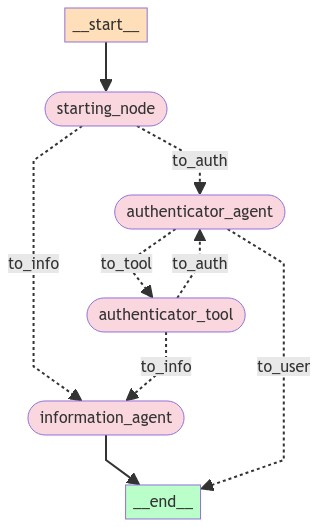

In [ ]:
# # # Utils
# from IPython.display import Image, display
# display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
# Agents
# from typing import Annotated, Union
# from typing_extensions import TypedDict
# from langgraph.graph import StateGraph
# from langgraph.graph.message import add_messages
# from langchain_google_vertexai import ChatVertexAI
# from langgraph.checkpoint.sqlite import SqliteSaver
# from datetime import datetime
# from langchain_core.prompts import ChatPromptTemplate
# from langchain_openai import ChatOpenAI
# import functools


# TODAY = str(datetime.now().date())
# gemini_model = ChatVertexAI(model_name="gemini-1.5-pro-preview-0409", temperature=0.0,)
# chatgtp_model = ChatOpenAI(model="gpt-4o", temperature=0, max_retries=2,)

# authenticator_prompt_content = dedent(f"""\
#     Definição: 
#     Você é um assistente de atendimento a usuários que são consumidores procurando informações sobre suas dívidas.
                              
#     Instruções: 
#     - Você deve obter o CPF e a data de nascimento do usuário. Esses dados serão usados para autenticá-lo e fornecer informações sobre suas dívidas.
#     - O CPF pode ser composto por 10 ou 11 dígitos númericos e o usuário pode enviar somente os números (e.g. 74132341062), com pontuação (e.g. 338.013.350-70). 
#     - A pontuação também pode vir incompleta ou incorreta (e.g. 794-169-380-17, e.g. 794.169.38017)
#     - A data de nascimento também pode ser enviada em diferentes formatos (e.g. 25-02-2000, 14/05/97, 1989-06-06). 
#     - Considere que os usuários são brasileiros, então é comum que o dia seja apresentado antes do mês na sequência.
#     - Quando estiver confiante que o usuário lhe forneceu um CPF e uma data de nascimento coerentes, você deve chamar a função 'checar_cpf'.
                              
#     Extras:
#     - Você sempre deve responder Português Brasileiro.
#     - Você tem acesso a todo histórico de mensagens da conversa.
#     - Hoje é {TODAY}."""
# )

# authenticator_prompt = ChatPromptTemplate.from_messages(
#     [
#         ("system", authenticator_prompt_content),
#         ("placeholder", "{messages}")
#     ]
# )

# def create_authenticator_agent(model, prompt):
#     return authenticator_prompt | model.bind_tools([authenticate_user_tool])

# def create_authenticator_node(state, agent):
#     return {"messages": [agent.invoke(state)]}

# assistant_node = functools.partial(create_authenticator_node, agent=create_authenticator_agent(chatgtp_model, authenticator_prompt))

In [ ]:
# Graph
# from typing import Annotated, Union
# from typing_extensions import TypedDict
# from langgraph.graph import StateGraph
# from langgraph.graph.message import add_messages
# from langchain_google_vertexai import ChatVertexAI
# from langgraph.checkpoint.sqlite import SqliteSaver
# from textwrap import dedent
# from datetime import datetime
# from langgraph.prebuilt import ToolNode, tools_condition

# memory = SqliteSaver.from_conn_string(DATABASES_PATH.joinpath("memory.db"))

# class State(TypedDict):
#     messages: Annotated[list, add_messages]
#     is_authenticated: Union[bool, None]
#     cpf: Union[str, None]
#     data_nascimento: Union[str, None]
#     nome: Union[str, None]
#     opcoes_pagamento: Union[str, None]
#     data_origem_divida: Union[str, None]
#     loja: Union[str, None]
#     produto: Union[str, None]

# graph_builder = StateGraph(State)

# graph_builder.add_node("assistant_node", assistant_node)

# graph_builder.set_entry_point("assistant_node")

# tool_node = ToolNode(tools=[authenticate_user_tool])
# graph_builder.add_node("tools", tool_node)

# graph_builder.add_conditional_edges("assistant_node", tools_condition)
# graph_builder.add_edge("tools", "assistant_node")

# graph = graph_builder.compile(checkpointer=memory)

In [ ]:
# from langgraph.prebuilt import ToolNode
# from langchain_core.messages import ToolMessage

# class AuthenticatorAgentNode():
#     def __init__(self, runnable):
#         self.runnable = runnable

#     def __call__(self, state):
#         return {"messages": [self.runnable.invoke(state)]}
    
    
# class AuthenticatorToolNode():
#     def __init__(self, runnable):
#         self.runnable = runnable

#     def __call__(self, state):
#         tool_call = state["messages"][-1].tool_calls[0]
#         tool = tools_by_name[tool_call["name"]]
#         args = tool_call["args"]
#         id = tool_call["id"]
#         observation = tool.invoke(args)
#         if isinstance(observation, str):
#             return {"messages": ToolMessage(content=observation, tool_call_id=id)}
#         else:
#             df = observation
#             state["is_authenticated"] = True
#             state["cpf"] = df["cpf_cnpj"].item()
#             state["data_nascimento"] = df["data_nascimento"].item()
#             state["nome"] = df["nome"].item()
#             state["opcoes_pagamento"] = df["Opcoes_Pagamento"].item()
#             state["data_origem_divida"] = df["data_origem"].item()
#             state["loja"] = df["loja"].item()
#             state["produto"] = df["produto"].item()
#             state["messages"] = ToolMessage(content="Usuário autenticado", tool_call_id=id)
#             return state

In [ ]:
# from langgraph.prebuilt import ToolNode
# from langchain_core.messages import ToolMessage

# class AuthenticatorAgentNode():
#     def __init__(self, runnable):
#         self.runnable = runnable

#     def __call__(self, state):
#         return {"messages": [self.runnable.invoke(state)]}
    
    
# class AuthenticatorToolNode():
#     def __init__(self, runnable):
#         self.runnable = runnable

#     def __call__(self, state):
#         tool_call = state["messages"][-1].tool_calls[0]
#         tool = tools_by_name[tool_call["name"]]
#         args = tool_call["args"]
#         id = tool_call["id"]
#         observation = tool.invoke(args)
#         if isinstance(observation, str):
#             return {"messages": ToolMessage(content=observation, tool_call_id=id)}
#         else:
#             df = observation
#             state["is_authenticated"] = True
#             state["cpf"] = df["cpf_cnpj"].item()
#             state["data_nascimento"] = df["data_nascimento"].item()
#             state["nome"] = df["nome"].item()
#             state["opcoes_pagamento"] = df["Opcoes_Pagamento"].item()
#             state["data_origem_divida"] = df["data_origem"].item()
#             state["loja"] = df["loja"].item()
#             state["produto"] = df["produto"].item()
#             state["messages"] = ToolMessage(content="Usuário autenticado", tool_call_id=id)
#             return state
        

# class AuthenticatorToInfoRouter():
#     def __init__(self):
#         pass
#     def __call__(self, state):
#         if state["is_authenticated"]:
#             return "to_info"
#         else:
#             return "back_to_auth"
        

# class InformationAgentNode():
#     def __init__(self, runnable):
#         self.runnable = runnable

#     def __call__(self, state):
#         information_prompt_content = dedent(f"""\
#             Definição: 
#             Você é um atendente de usuários que são consumidores procurando informações sobre suas dívidas.
                                            
#             Objetivo: 
#             Falar o nome do usuário.
                                            
#            [[opcao_pagamento_id: 278407055, valor_entrada: 0, valor_parcela: 460,09, valor_desconto: 7336,86, valor_negociado: 7796,95, quantidade_parcelas: 1, data_primeiro_boleto: 31/08/2024], [opcao_pagamento_id: 278407060, valor_entrada: 0, valor_parcela: 126,09, valor_desconto: 7040,39, valor_negociado: 7796,95, quantidade_parcelas: 6, data_primeiro_boleto: 31/08/2024], [opcao_pagamento_id: 278407066, valor_entrada: 0, valor_parcela: 63,05, valor_desconto: 7040,39, valor_negociado: 7796,95, quantidade_parcelas: 12, data_primeiro_boleto: 31/08/2024]]
                                    
#             Instruções: 
#             - O nome completo do usuário é {state["nome"]}. Sempre que adequado, chame-o pelo primeiro nome.
#             - Informe o número de possíveis opções de pagamento, características de cada opção e qual é a opção com maior porcentagem de desconto e opção com o prazo mais longo.
#             - Use somente os dados do array de JSONs
            
#             Extras:
#             - Você sempre deve responder no idioma Português Brasileiro.
#             - Hoje é {TODAY}."""
#         )
        
#         information_prompt = ChatPromptTemplate.from_messages(
#             [
#                 ("system", information_prompt_content),
#                 ("placeholder", "{messages}"),
#             ]
#         )
#         updated_runnable = information_prompt | self.runnable
#         return {"messages": [updated_runnable.invoke(state)]}

In [ ]:
# .assign(Opcoes_Pagamento=lambda _df: _df["Opcoes_Pagamento"].str.replace('"',"").replace("{", "{{").replace("}", "}}")

In [ ]:
# from typing import Annotated, Union
# from typing_extensions import TypedDict
# from langgraph.graph import StateGraph, END
# from langgraph.graph.message import add_messages
# from langchain_google_vertexai import ChatVertexAI
# from langgraph.checkpoint.sqlite import SqliteSaver
# from langchain_google_vertexai import ChatVertexAI
# from langchain_openai import ChatOpenAI

# DATABASES_PATH = Path.cwd().parent.joinpath("data").joinpath("databases")
# gemini_model = ChatVertexAI(model_name="gemini-1.5-pro-preview-0409", temperature=0.0, max_retries=2)
# chatgpt_model = ChatOpenAI(model="gpt-4o", temperature=0, max_retries=2,)
# memory = SqliteSaver.from_conn_string(DATABASES_PATH.joinpath("memory.db"))

# class State(TypedDict):
#     messages: Annotated[list, add_messages]
#     is_authenticated: Union[bool, None]
#     cpf: Union[str, None]
#     data_nascimento: Union[str, None]
#     nome: Union[str, None]
#     opcoes_pagamento: Union[str, None]
#     data_origem_divida: Union[str, None]
#     loja: Union[str, None]
#     produto: Union[str, None]


# graph_builder = StateGraph(State)

# graph_builder.add_node("starting_node",  StartNode())
# graph_builder.add_node("authenticator_agent", AuthenticatorAgentNode(chatgpt_model))
# graph_builder.add_node("authenticator_tool", AuthenticatorToolNode(authenticate_user_tool))
# graph_builder.add_node("information_agent", InformationAgentNode(chatgpt_model))

# graph_builder.set_entry_point("starting_node")
# graph_builder.add_conditional_edges(
#     "starting_node",
#     AuthenticatorOrInfoRouter(),
#     {"to_auth": "authenticator_agent", "to_info": "information_agent",},
# )
# graph_builder.add_conditional_edges(
#     "authenticator_agent",
#     ToolRouter(),
#     {"to_tool": "authenticator_tool", "to_user": END,},
# )
# graph_builder.add_conditional_edges(
#     "authenticator_tool",
#     AuthenticatorOrInfoRouter(),
#     {"to_auth": "authenticator_agent", "to_info": "information_agent",},
# )
# graph_builder.set_finish_point("information_agent")

# graph = graph_builder.compile(checkpointer=memory)